# USNCCM 2023

# Short course: SC17-003: Machine Learning for Solid

# **Autoencoder-Embedding Data-Driven Computing**


Instructor: Prof. QiZhi He (University of Minnesota)

Contributors:
Xiaolong He (ANSYS)
Honghui Du (UMN)

# Manifold Bio


    Train an Autoencoder using data of heart valve tissue
    
    Output: statistics for data normalization, weights and bias of trained autoencoder

In [ ]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data

from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import time
import numpy.linalg as la

In [ ]:
# Import customized libraries
import sys
path_folder = '/content/Autoencoder/'
sys.path.append(path_folder+'/subcodes')
from getData import getDataBio
import getModel
from plotDataBio import plotTrainData, plotNNoutput, plotTest, plotEmbedding

plt.rcParams.update({'font.size': 20})  # fontsize for figures
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# Create folders to store figures and training weights
if not os.path.exists(path_folder+'/figures'):
  os.mkdir(path_folder+'/figures')
if not os.path.exists(path_folder+'/weights'):
  os.mkdir(path_folder+'/weights')

# Parameters

In [ ]:
loadCheckPoint = 0  # 1: Load saved NN model
use_gpu = 0         # 1: Use gpu for computation
LR = 1e-1           # Learning Rate
weight_decay = 1e-5 # L2 Weight regularization
EPOCH = 1000         # Total number of training steps/epochs
BATCH_SIZE = 1      # number of training samples per batch training

In [ ]:
#trainID = list(range(1,10)) # protocol ID of training dataset
#testID = [2,6]              # protocol ID of testing dataset

# Case 1
#trainID = [1,3,4,7,8,10,11]
#testID = [2,5,6,9]

# Case 2
#trainID = [1,3,4,7,8]
#testID = [2,5,6,9]

# Case 3
# trainID = [1,2,6,10,11]
# testID = [3,4,7,8]

# Case 3b
# trainID = [1,2,6]
# testID = [3,4,7,8]

# Case 4
trainID = [2,5,7,8]
testID = [1,3,4]

# Case 5
trainID = [1,2,3,4,5,6,7,8,9]
testID = [10,11]

# Case 6
# trainID = [1,2,3,4,5,6,7,8,9,10]
# testID = [11]

# Case 7
# trainID = [1,2,3,4,5,6,7,8,9,11]
# testID = [10]


In [ ]:
#==============================================================================
# GPU Setting
if use_gpu == 1:
    # setting device on GPU if available, else CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    print()

    # select gpus
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.cuda.init() # initialize gpu



## Preprocessing Datasets

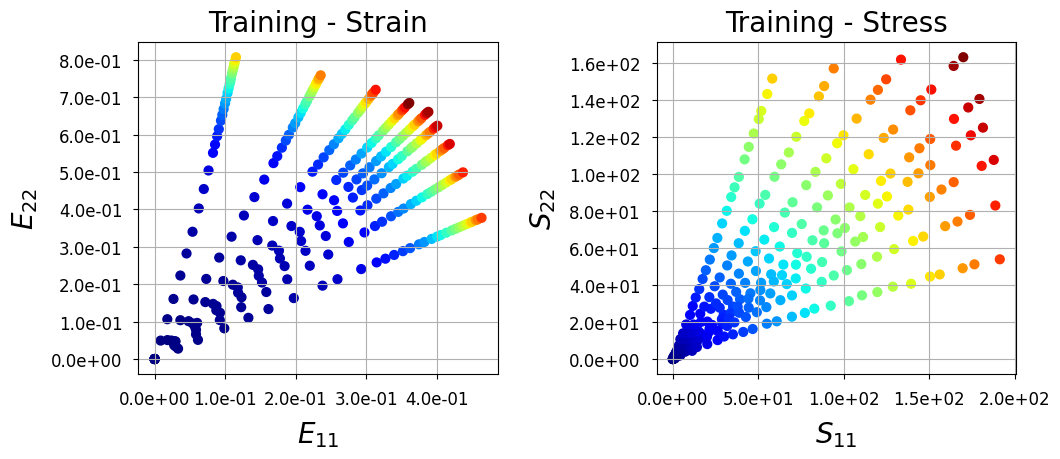

In [ ]:
# Get Training and Testing Datasets (Green Strain and 2nd PK Stress)
s0_train, s0_test = getDataBio(path_folder +'./dataset/data_1-11_biopaper.txt',trainID,testID)
color_train = la.norm(s0_train,axis=1)
if len(testID) != 0: color_test = la.norm(s0_test,axis=1)
plotTrainData(s0_train,color_train,path_folder)
plt.show()

In [ ]:
#==============================================================================
# Standardization
print('Before Standardization *************************************')
print('s0_train mean: ', s0_train.mean(axis=0))
print('s0_train std: ', s0_train.std(axis=0))
if len(testID) != 0:
    print('s0_test mean: ', s0_test.mean(axis=0))
    print('s0_test std: ', s0_test.std(axis=0))
print()

s_train_scaler = preprocessing.StandardScaler().fit(s0_train)
s_train = s_train_scaler.transform(s0_train)
if len(testID) != 0:
    s_test = s_train_scaler.transform(s0_test)
print('After Standardization **************************************')
print('s_train mean: ', s_train.mean(axis=0))
print('s_train std: ', s_train.std(axis=0))
if len(testID) != 0:
    print('s_test mean: ', s_test.mean(axis=0))
    print('s_test std: ', s_test.std(axis=0))
print()

#==============================================================================
# Transform Standardized Data to Tensor Form
if use_gpu == 1:
    s_train = torch.from_numpy(s_train).cuda()
    if len(testID) != 0: s_test = torch.from_numpy(s_test).cuda()

    # Cuda usage info
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated: %.16f' % round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:    %.16f' % round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
        print()
else:
    s_train = torch.from_numpy(s_train)
    if len(testID) != 0: s_test = torch.from_numpy(s_test)


Before Standardization *************************************
s0_train mean:  [ 0.24619669  0.44487488  0.         58.295265   49.466293    0.        ]
s0_train std:  [ 0.12843134  0.20957501  0.         53.468235   44.185223    0.        ]
s0_test mean:  [ 0.04848654  0.18770406  0.         19.262808   20.483618    0.        ]
s0_test std:  [ 0.2998895   0.40513706  0.         43.33466    36.214       0.        ]

After Standardization **************************************
s_train mean:  [ 3.6877694e-08 -3.4304832e-09  0.0000000e+00  3.3345870e-08
 -6.8609665e-09  0.0000000e+00]
s_train std:  [1.0000001 1.0000001 0.        1.0000004 1.0000001 0.       ]
s_test mean:  [-1.5394232 -1.227106   0.        -0.7300124 -0.6559359  0.       ]
s_test std:  [2.3350184  1.9331362  0.         0.8104752  0.81959516 0.        ]



In [ ]:
#==============================================================================
#   Define Autoencoder Architecture, Training Algorithms, and Loss Function
#==============================================================================
# Parameter setting of networks
nnode_encoder = [6,4,3]                # number of nodes in each layer of Encoder, including input layer
nh_encoder = len(nnode_encoder)-1      # number of hidden layers of Encoder
save_weight = 1                        # 1: save trained weights and bias

# Construct Model, Activation: act_type = 1 (ReLU), 2 (Tanh), 3 (Sigmoid)
if use_gpu == 1:
    net = getModel.AE(nnode_encoder,act_type=2).cuda()
else:
    net = getModel.AE(nnode_encoder,act_type=2)
print(net)

#==============================================================================
# Load Saved Model if Specified
if loadCheckPoint == 1: # load a saved NN model
    optimizer = torch.optim.Adagrad(net.parameters())
    checkpoint = torch.load('checkpoint.pth.tar')
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    net.train()

#==============================================================================
# Define Optimizer if No Model is Loaded
else:
#    optimizer = torch.optim.SGD(net.parameters(), lr = 0.2, momentum = 0.9)
#    optimizer = torch.optim.Adam(net.parameters(), lr = 1e-2)
#    optimizer = torch.optim.Adadelta(net.parameters(), lr = 1e-0, rho = 0.9,
#                                    eps = 1e-6, weight_decay = 0)
    optimizer = torch.optim.Adagrad(net.parameters(),lr=LR,lr_decay=0,
                                    weight_decay=weight_decay,initial_accumulator_value=0)
#    optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-2)
#    optimizer = torch.optim.Rprop(net.parameters(), lr=1e-2)

#==============================================================================
# Define Loss Function: Mean Squared Error Loss (MSEloss) - for Regression
if use_gpu == 1:
    loss_func = nn.MSELoss().cuda()
else:
    loss_func = nn.MSELoss()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=6, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=6, bias=True)
  )
)


# Training Autoencoder

In [ ]:
# Use Dataloader to load Training data for each training step
torch_dataset = Data.TensorDataset(s_train,s_train)
loader = Data.DataLoader(dataset = torch_dataset, batch_size = BATCH_SIZE,
        shuffle = True, num_workers = 0)

lossTrain = np.zeros((EPOCH,1)) # store history of training loss
lossTest = np.zeros((EPOCH,1))  # store history of testing loss
s0_train_tensor = torch.from_numpy(s0_train)    # transform Training state (original scale) to tensor form for computing loss
if len(testID) != 0: s0_test_tensor = torch.from_numpy(s0_test)   # transform Testing state (original scale) to tensor form for computing loss
startT = time.time()         # start the timer to track the training time

#==============================================================================
# Start Training
for epoch in range(EPOCH):  # loop over all training epochs
    # loop over all training steps in each epoch
    for step, (b_x,b_y) in enumerate(loader):
        pred = net(b_x)            # input x and predict based on x
        loss = loss_func(pred,b_y) # must be (1. nn output, 2. target)
        optimizer.zero_grad()      # clear gradients for next train
        loss.backward()            # backpropagation, compute gradients
        optimizer.step()           # apply gradients to update connection weights

    lossTrain[epoch] = loss_func(net(s_train),s_train).data.numpy()  # save training loss
    lossTest[epoch] = loss_func(net(s_test),s_test).data.numpy()  # save training loss

    print('Epoch: %d  |' % epoch, 'Scaled Training Loss: %.8f' % lossTrain[epoch]) # scaled
    print('Epoch: %d  |' % epoch, 'Scaled Testing Loss: %.8f' % lossTest[epoch]) # scaled

endT = time.time()
print('***************** Training time:', endT-startT)

predTr = s_train_scaler.inverse_transform(net(s_train).data.numpy())
print('Training Loss in Original Scale: %.8f' % loss_func(torch.from_numpy(predTr),s0_train_tensor))
if len(testID) != 0:
    predTe = s_train_scaler.inverse_transform(net(s_test).data.numpy())
    print('Testing Loss in Original Scale: %.8f' % loss_func(torch.from_numpy(predTe),s0_test_tensor))


Epoch: 0  | Scaled Training Loss: 0.06271379
Epoch: 0  | Scaled Testing Loss: 0.80993342
Epoch: 1  | Scaled Training Loss: 0.03080461
Epoch: 1  | Scaled Testing Loss: 0.71028239
Epoch: 2  | Scaled Training Loss: 0.01807928
Epoch: 2  | Scaled Testing Loss: 0.61311173
Epoch: 3  | Scaled Training Loss: 0.01409075
Epoch: 3  | Scaled Testing Loss: 0.59227270
Epoch: 4  | Scaled Training Loss: 0.01297322
Epoch: 4  | Scaled Testing Loss: 0.55703348
Epoch: 5  | Scaled Training Loss: 0.01120900
Epoch: 5  | Scaled Testing Loss: 0.53280407
Epoch: 6  | Scaled Training Loss: 0.01036320
Epoch: 6  | Scaled Testing Loss: 0.51845485
Epoch: 7  | Scaled Training Loss: 0.00992111
Epoch: 7  | Scaled Testing Loss: 0.51611143
Epoch: 8  | Scaled Training Loss: 0.00967801
Epoch: 8  | Scaled Testing Loss: 0.49760067
Epoch: 9  | Scaled Training Loss: 0.00945042
Epoch: 9  | Scaled Testing Loss: 0.50314677
Epoch: 10  | Scaled Training Loss: 0.01151175
Epoch: 10  | Scaled Testing Loss: 0.48635414
Epoch: 11  | Scaled

# Post-Processing

## Save training results

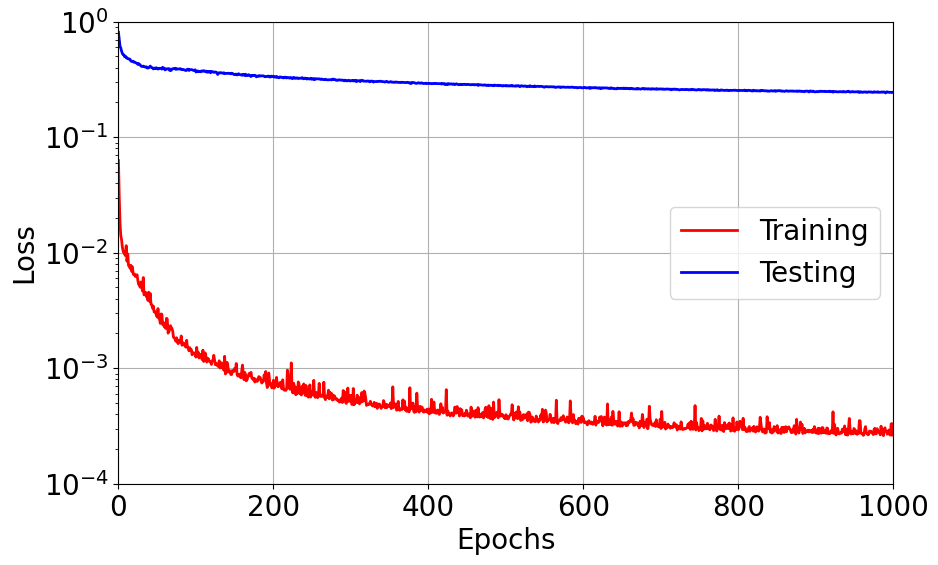

In [ ]:
#==============================================================================
# Plot History of Training Loss
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(EPOCH),lossTrain,'r-',lw=2,label='Training')
ax.plot(range(EPOCH),lossTest,'b-',lw=2,label='Testing')
ax.grid(which='major',axis='both')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.yscale("log")
plt.legend()
ax.set_xlim(0,EPOCH)
ax.set_ylim(1e-4,1e0)
plt.savefig(path_folder + './figures/loss.png')


In [34]:
#==============================================================================
# Save Check Point of model, which can be loaded for continuous training
torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'lossTrain':lossTrain,
            }, path_folder+'checkpoint.pth.tar')


#==============================================================================
# Extract Learned Connection Weights and Bias
encoder_w = []
encoder_bias = []
decoder_w = []
decoder_bias = []

for i in range(nh_encoder):
    encoder_w.append(net.encoder[i*2].weight.data.numpy())
    encoder_bias.append(net.encoder[i*2].bias.data.numpy())
    decoder_w.append(net.decoder[i*2].weight.data.numpy())
    decoder_bias.append(net.decoder[i*2].bias.data.numpy())

#==============================================================================
# Export Connection Weights and Bias to Files
if save_weight == 1:
    np.savetxt(path_folder+'./weights/s_train_scaler.txt',np.concatenate((s_train_scaler.mean_,s_train_scaler.scale_), axis=0))
    for i in range(nh_encoder):
        np.savetxt(path_folder+f'./weights/encoder_w{i+1}.txt',encoder_w[i])
        np.savetxt(path_folder+f'./weights/encoder_bias{i+1}.txt',encoder_bias[i])
        np.savetxt(path_folder+f'./weights/decoder_w{i+1}.txt',decoder_w[i])
        np.savetxt(path_folder+f'./weights/decoder_bias{i+1}.txt',decoder_bias[i])



```
# This is formatted as code
```

## Test and visualize training model

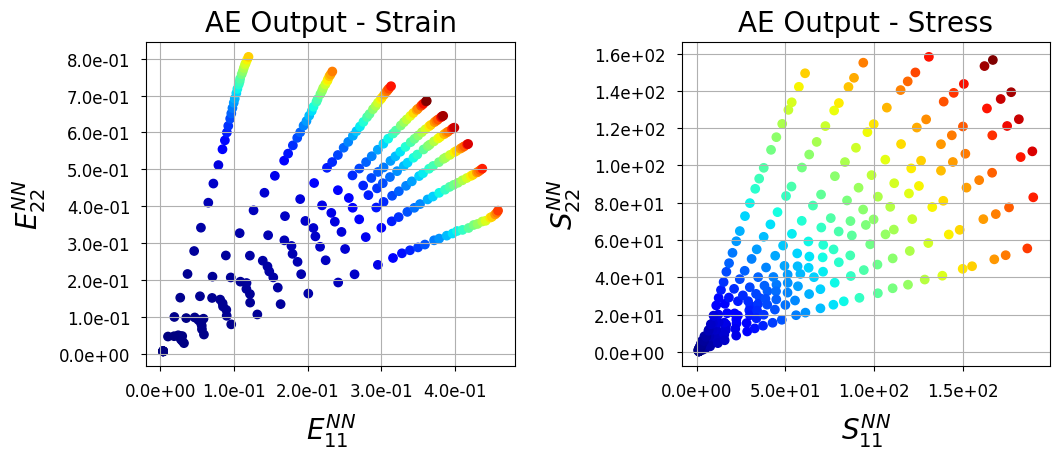

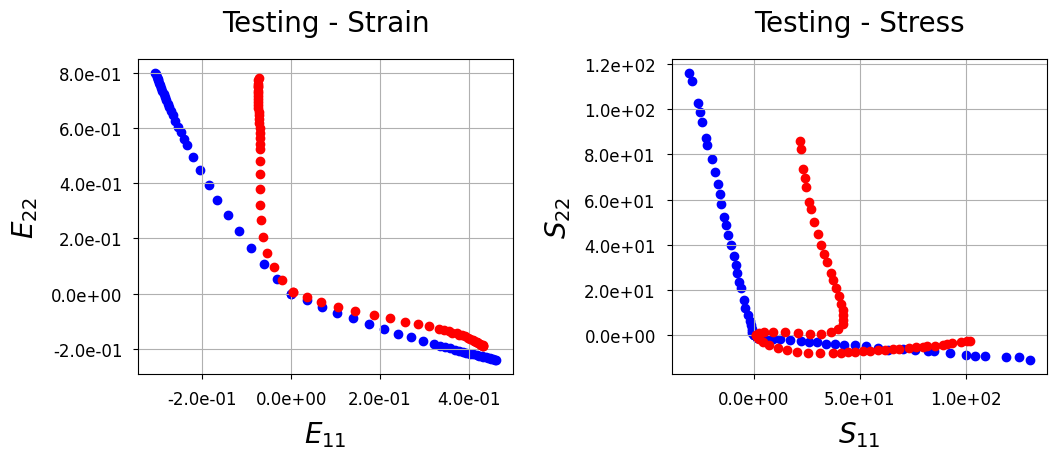

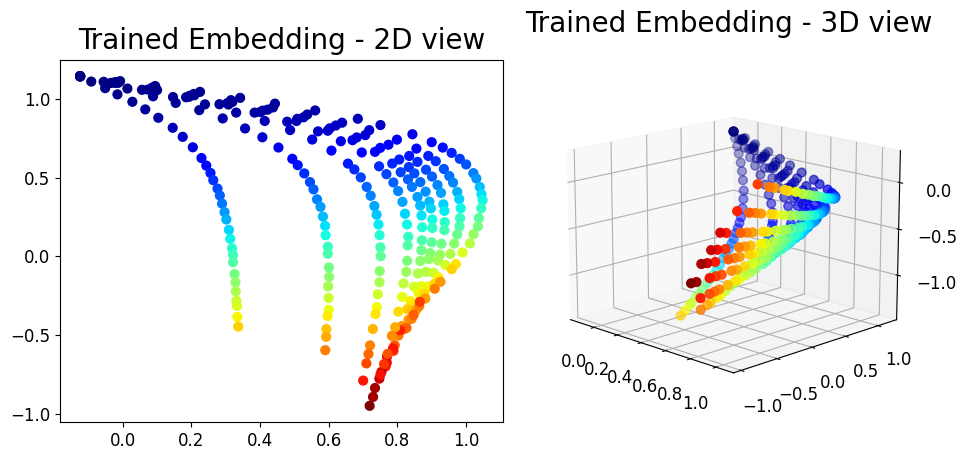

In [35]:
#==============================================================================
# Evaluate Trained NN on Training Set
plotNNoutput(predTr,color_train,path_folder)

#==============================================================================
# Evaluate Trained NN on Testing Set
if len(testID) != 0:
#    plotTestStrain(s0_test[:,0:3],predTe[:,0:3],color_test)
#    plotTestStress(s0_test[:,3:6],predTe[:,3:6],color_test)
    plotTest(s0_test,predTe,path_folder)

#==============================================================================
# Visualize Trained Embedding
embedding = net.encode(s_train)
plotEmbedding(embedding.data.numpy(),color_train,path_folder)
